In [1]:
import chipwhisperer as cw
import numpy as np
import scienceplots
import matplotlib.pyplot as plt

import simon_64_128_simulation
import correlations

from measurement import Measurements

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [2]:
# project = cw.import_project("./traces/07_simon_plain_50000/trace.zip", overwrite=True)
# project = cw.import_project("./traces/10_simon_masked_50000/trace.zip", overwrite=True)
project = cw.import_project("./traces/12_simon_masked_50000/trace.zip", overwrite=True)

In [3]:
TOTAL_NUM_MEASUREMENTS = len(project.traces)
TOTAL_VALS_PER_MEASUREMENT = len(project.traces[0].wave)

# Only use a subset
NUM_MEASUREMENTS = 50000
VALS_PER_MEASUREMENT = 800

# Transform Trace Project into Measurement object

In [4]:
plaintexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((TOTAL_NUM_MEASUREMENTS, TOTAL_VALS_PER_MEASUREMENT), dtype=np.uint32)

for i, trace in enumerate(project.traces):

    pt = trace.textin
    ct = trace.textout

    plaintexts[i,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
    plaintexts[i,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

    ciphertexts[i,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
    ciphertexts[i,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
    powers[i,:] = trace.wave

measurements = Measurements(plaintexts[0:NUM_MEASUREMENTS], ciphertexts[0:NUM_MEASUREMENTS], powers[0:NUM_MEASUREMENTS, 0:VALS_PER_MEASUREMENT])

In [5]:
# key = np.array([0x8dcc04b1, 0xad004534, 0x8afa7151, 0xf173d6d7], dtype=np.uint32)
key = np.array([0xad828bc8, 0x3bada07c, 0xc80bf12f, 0x75c03156], dtype=np.uint32).view(dtype=np.uint32)


guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF)
)
print(expected_hws.shape)

corrs = correlations.Corr((256,VALS_PER_MEASUREMENT))

# Number of measurements to include into correlcation calculation at once
n = 10

# Interval for displaying correlations in diagram
di = 50
best_corrs_over_num_measurements = np.zeros((256,NUM_MEASUREMENTS//di), dtype=np.float64)


for i in range(0,NUM_MEASUREMENTS, n):
    corrs.update(expected_hws[i:i+n,:], measurements.power[i:i+n,:]) 
    if i % di == 0:
        idx = i // di
        best_corrs_over_num_measurements[:, idx] = corrs.max(axis=1)


(50000, 256)


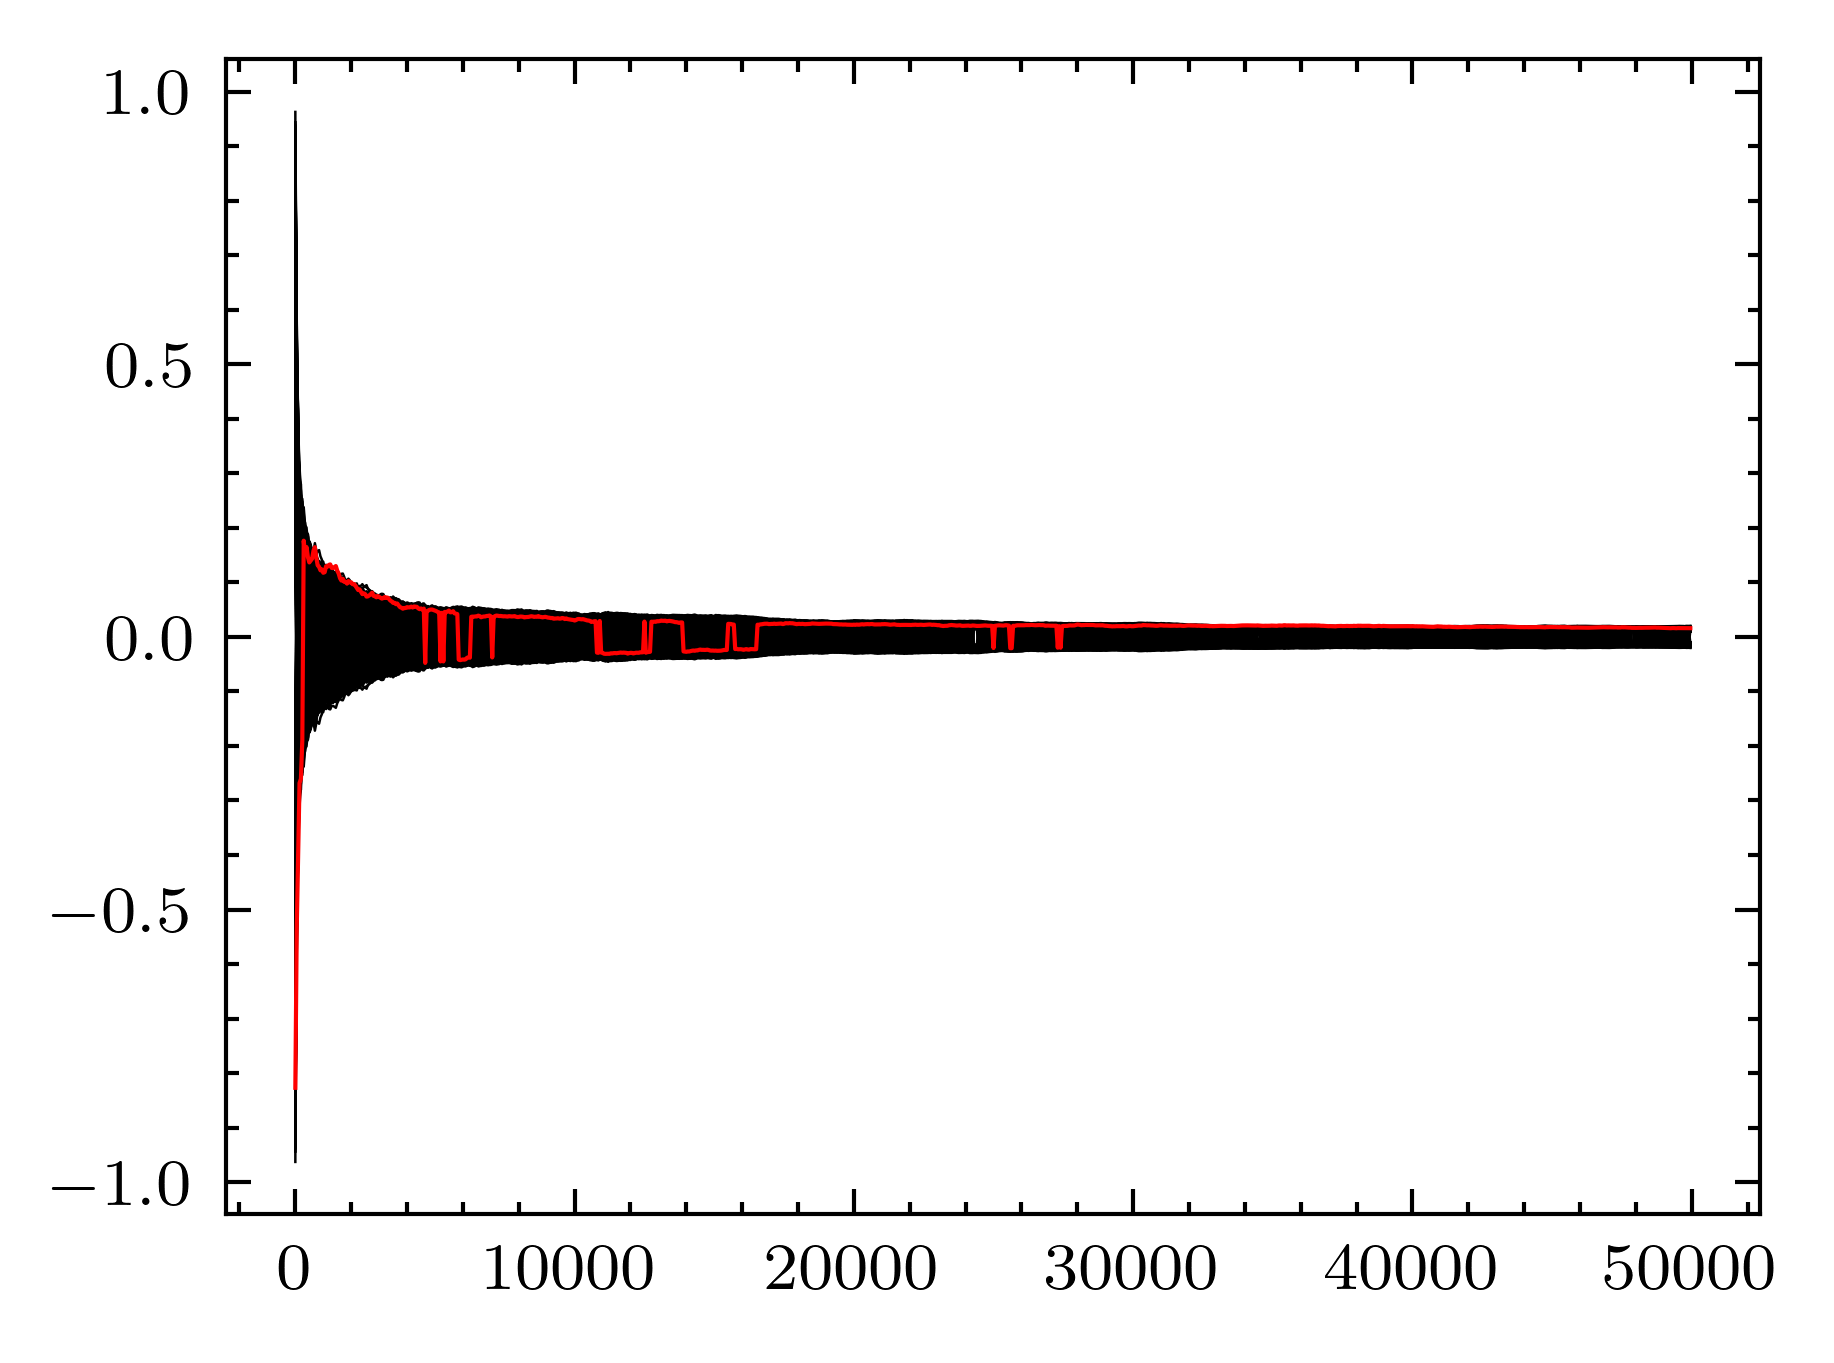

In [6]:
x = np.arange(0, NUM_MEASUREMENTS, step=di)
correct_byte = int(key[3] & 0xFF)

with plt.style.context(['science', 'ieee']):
    for i in range(256):
        plt.plot(x, best_corrs_over_num_measurements[i], color="black", linewidth=0.3, linestyle="-")
    plt.plot(x, best_corrs_over_num_measurements[correct_byte], color="red", linewidth=0.5, linestyle="-")
    plt.savefig("diagrams/correlation_over_num_measurements_masked.pdf")
    plt.savefig("diagrams/correlation_over_num_measurements_masked.pgf")